# Notebook with useful EDA, Preprocessing, FE functions

In [1]:
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.linear_model import LogisticRegression  
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier 
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from xgboost import XGBClassifier
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score, GridSearchCV,train_test_split,cross_val_score
import itertools
from sklearn.preprocessing import PolynomialFeatures
from sklearn.neighbors import LocalOutlierFactor
from sklearn.preprocessing import scale,StandardScaler, MinMaxScaler,Normalizer,RobustScaler
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report
from sklearn.metrics import  accuracy_score, f1_score, precision_score,confusion_matrix, recall_score, roc_auc_score
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.ensemble import RandomForestClassifier,AdaBoostClassifier,GradientBoostingClassifier


import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 
warnings.filterwarnings("ignore", category=FutureWarning) 
warnings.filterwarnings("ignore", category=UserWarning) 

%config InlineBackend.figure_format = 'retina'

pd.set_option('display.max_columns', None); pd.set_option('display.max_rows', None);
pd.set_option('display.float_format', lambda x: '%.2f' % x)




In [3]:
df = pd.read_csv("churn.csv", index_col=0)
df.head(10)

,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
RowNumber,,,,,,,,,,,,,
1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0
6,15574012,Chu,645,Spain,Male,44,8,113755.78,2,1,0,149756.71,1
7,15592531,Bartlett,822,France,Male,50,7,0.00,2,1,1,10062.80,0
8,15656148,Obinna,376,Germany,Female,29,4,115046.74,4,1,0,119346.88,1
9,15792365,He,501,France,Male,44,4,142051.07,2,0,1,74940.50,0


# EDA

In [4]:
dependent_variable_name = "Exited"

In [14]:
#checking missing values
def data_prepare():
    df_prep = df.copy()
    
    missing_value_len = df.isnull().any().sum()
    if missing_value_len == 0:
        print("No Missing Values in Dataset")
    else:
        print("Investigate Missing Value, Missing Value : " + str(missing_value_len))
    show_unique_count_variables(df = df_prep)
    
    df_prep['Tenure'] =  df_prep.Tenure.astype(np.float)
    df_prep['NumOfProducts'] =  df_prep.NumOfProducts.astype(np.float)
    return df_prep


In [15]:
#showing unique elements of every feature
def show_unique_count_variables(df):
    print('Unique elements of every feature:')
    for index, value in df.nunique().items():
        print(str(index) + "\t"*4 + ":" + str(value))

In [16]:
df_prep = data_prepare()

No Missing Values in Dataset
Unique elements of every feature:
CustomerId				:10000
Surname				:2932
CreditScore				:460
Geography				:3
Gender				:2
Age				:70
Tenure				:11
Balance				:6382
NumOfProducts				:4
HasCrCard				:2
IsActiveMember				:2
EstimatedSalary				:9999
Exited				:2


In [20]:
#Outliers observation using LOF method (sklearn)
def lof_observation(df):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    df_num_cols = df.select_dtypes(include=numerics)
    df_outlier = df_num_cols.astype("float64")
    clf = LocalOutlierFactor(n_neighbors = 20, contamination = 0.1)
    clf.fit_predict(df_outlier)
    df_scores = clf.negative_outlier_factor_
    scores_df = pd.DataFrame(np.sort(df_scores))
    
    scores_df.plot(stacked=True, xlim = [0,20], color='r', title='Visualization of outliers according to the LOF method', style = '.-');                # first 20 observe
    th_val = np.sort(df_scores)[2]
    outliers = df_scores > th_val
    df = df.drop(df_outlier[~outliers].index)
    df.shape
    return df

In [22]:
#Left outliers in age and credit score correction
def clear_outliers(df):
    
    Q1 = df["Age"].quantile(0.25)
    Q3 = df["Age"].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    print("When age and credit score is printed below lower score: ", lower, "and upper score: ", upper)
    df_outlier = df["Age"][(df["Age"] > upper)]
    df["Age"][df_outlier.index] = upper
    
    Q1 = df["CreditScore"].quantile(0.25)
    Q3 = df["CreditScore"].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    print("When age and credit score is printed above lower score: ", lower, "and upper score: ", upper)
    df_outlier = df["CreditScore"][(df["CreditScore"] < lower)]
    df["CreditScore"][df_outlier.index] = lower
    
    return df

In [17]:
def show_outliers(df):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    df_num_cols = df.select_dtypes(include=numerics)
    sns.set(font_scale = 0.7) 
    fig, axes = plt.subplots(nrows = 2, ncols = 5, gridspec_kw =  dict(hspace=0.3), figsize = (12,9))
    fig.tight_layout()
    for ax,col in zip(axes.flatten(), df_num_cols.columns):
        sns.boxplot(x = df_num_cols[col], color='green', ax = ax)
    fig.suptitle('Observing Outliers', color = 'r', fontsize = 14)

In [25]:
def outlier_process(df):
    df_outlier = lof_observation(df = df)
    df_outlier = clear_outliers(df = df_outlier)
    return df_outlier

When age and credit score is printed below lower score:  14.0 and upper score:  62.0
When age and credit score is printed above lower score:  383.0 and upper score:  919.0


<ipython-input-22-4c2959a9fe10>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Age"][df_outlier.index] = upper
<ipython-input-22-4c2959a9fe10>:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["CreditScore"][df_outlier.index] = lower


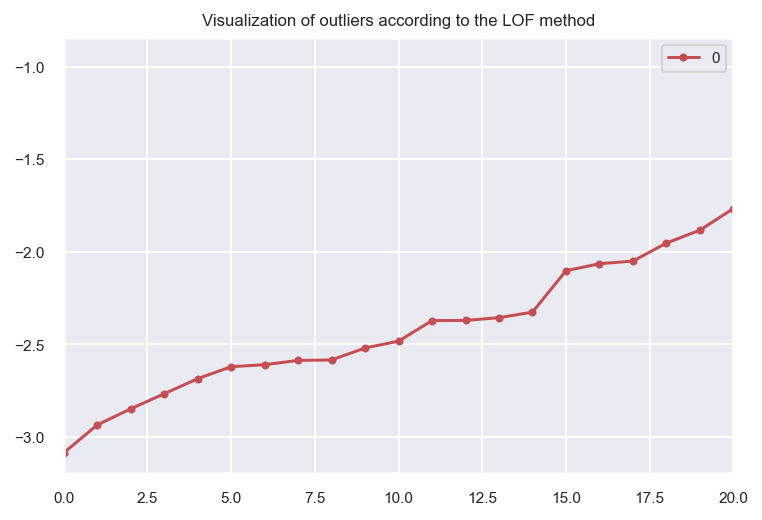

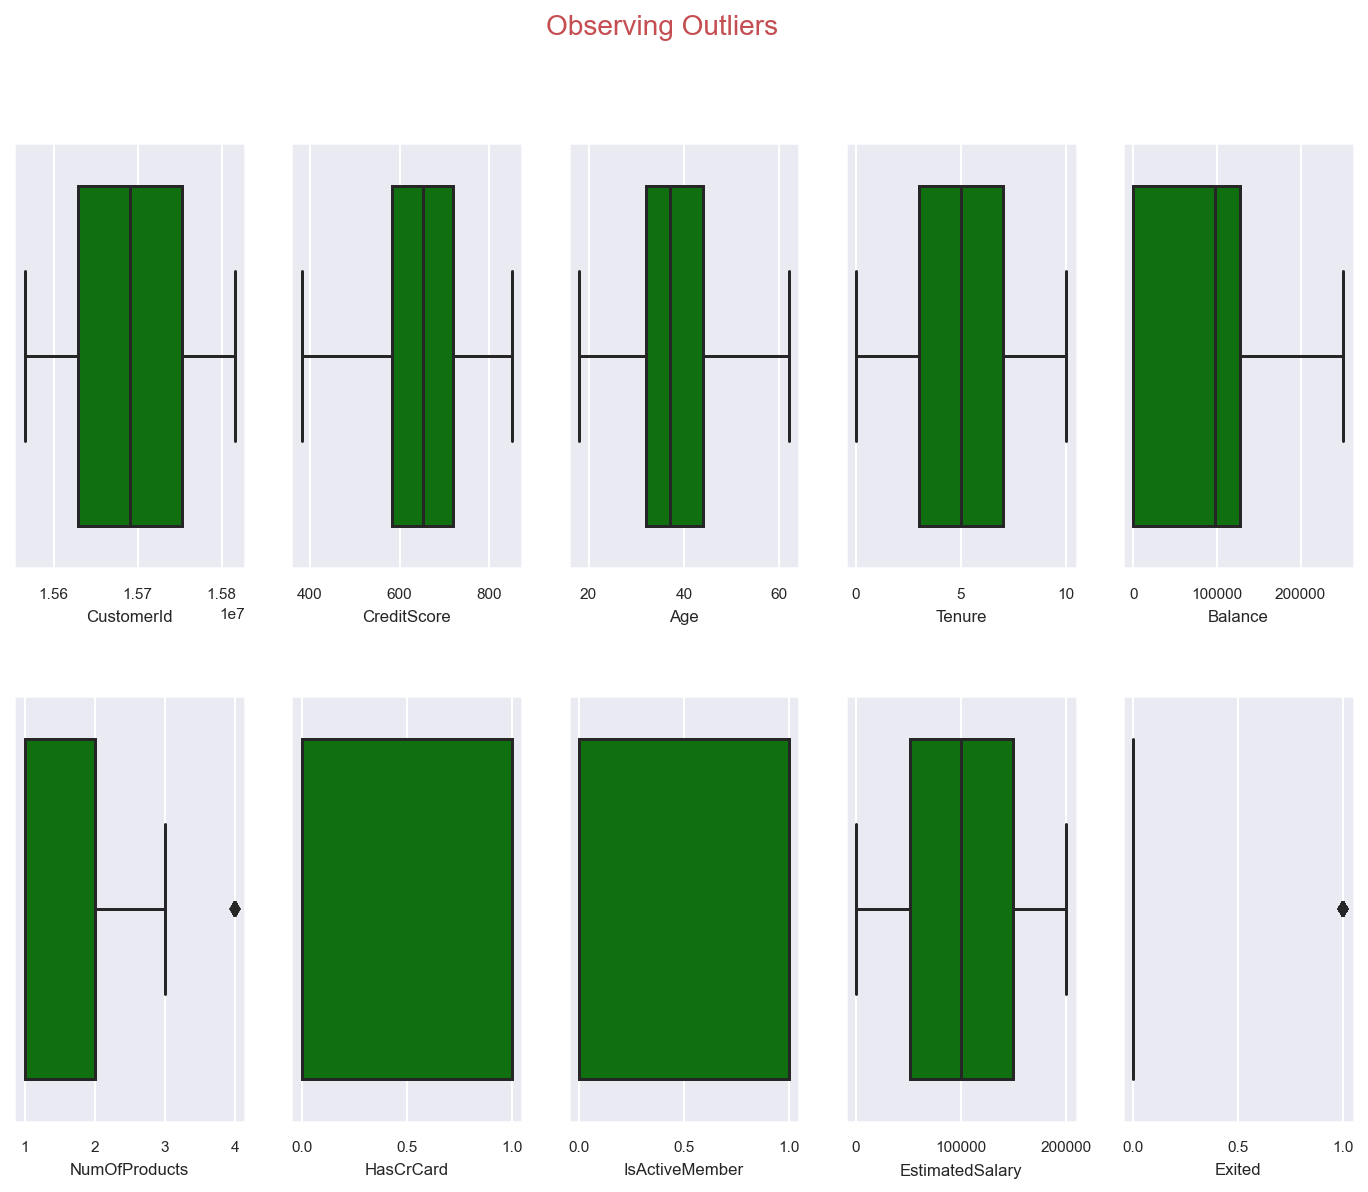

In [26]:
df_outlier = outlier_process(df = df_prep)
show_outliers(df = df_outlier)

In [28]:
def show_dependent_variable(df):
    fig, axarr = plt.subplots(2, 3, figsize=(18, 6))
    sns.countplot(x = 'Geography', hue = 'Exited',data = df, ax = axarr[0][0])
    sns.countplot(x = 'Gender', hue = 'Exited',data = df, ax = axarr[0][1])
    sns.countplot(x = 'HasCrCard', hue = 'Exited',data = df, ax = axarr[0][2])
    sns.countplot(x = 'IsActiveMember', hue = 'Exited',data = df, ax = axarr[1][0])
    sns.countplot(x = 'NumOfProducts', hue = 'Exited',data = df, ax = axarr[1][1])
    sns.countplot(x = 'Tenure', hue = 'Exited',data = df, ax = axarr[1][2])
    zero, one = df[dependent_variable_name].value_counts()
    print("Dependent variable distribution;")
    print(dependent_variable_name + " 0 count:", zero)
    print(dependent_variable_name + " 1 count:", one)

Dependent variable distribution;
Exited 0 count: 7961
Exited 1 count: 2036


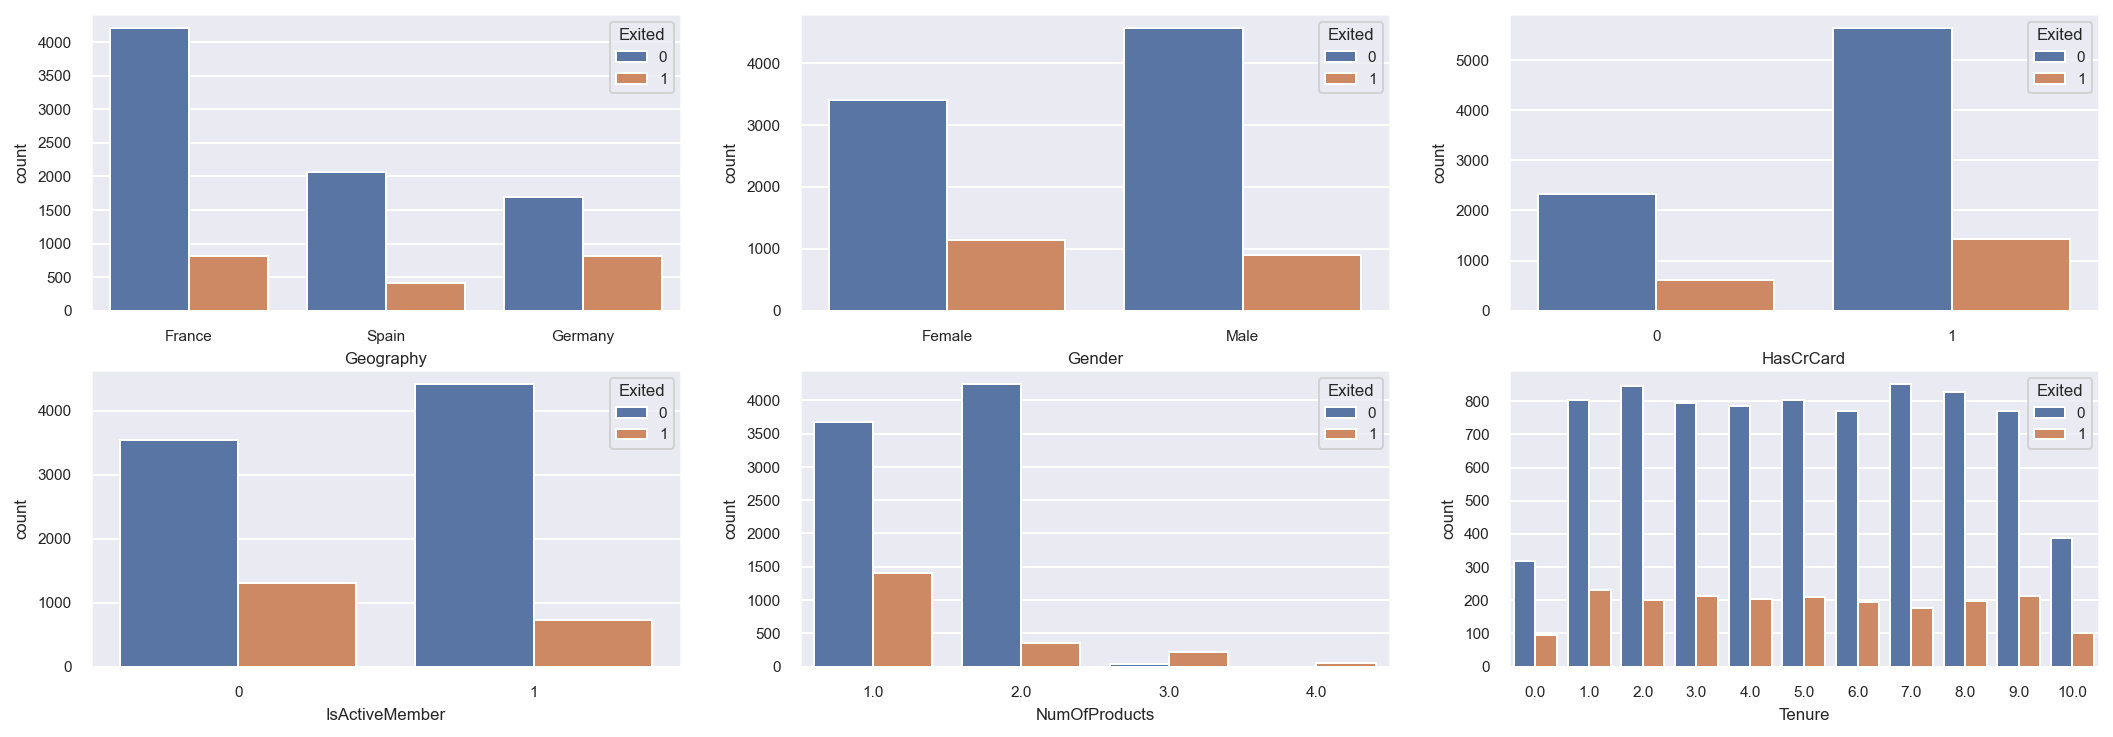

In [32]:
#show_dependent_variable(df_prep)
show_dependent_variable(df_outlier)

In [33]:
def show_numeric_columns_distributions(df):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    df_num_cols = df.select_dtypes(include=numerics)
    columns = df_num_cols.columns[: len(df_num_cols.columns)]
    fig = plt.figure()
    fig.set_size_inches(18, 15)
    length = len(columns)
    for i,j in itertools.zip_longest(columns, range(length)):
        plt.subplot((length / 2), 3, j+1)
        plt.subplots_adjust(wspace = 0.2, hspace = 0.5)
        df_num_cols[i].hist(bins = 20, edgecolor = 'black')
        plt.title(i)
    fig = fig.suptitle('Structures of numeric variables', color = 'r' ,fontsize = 18)
    plt.show()

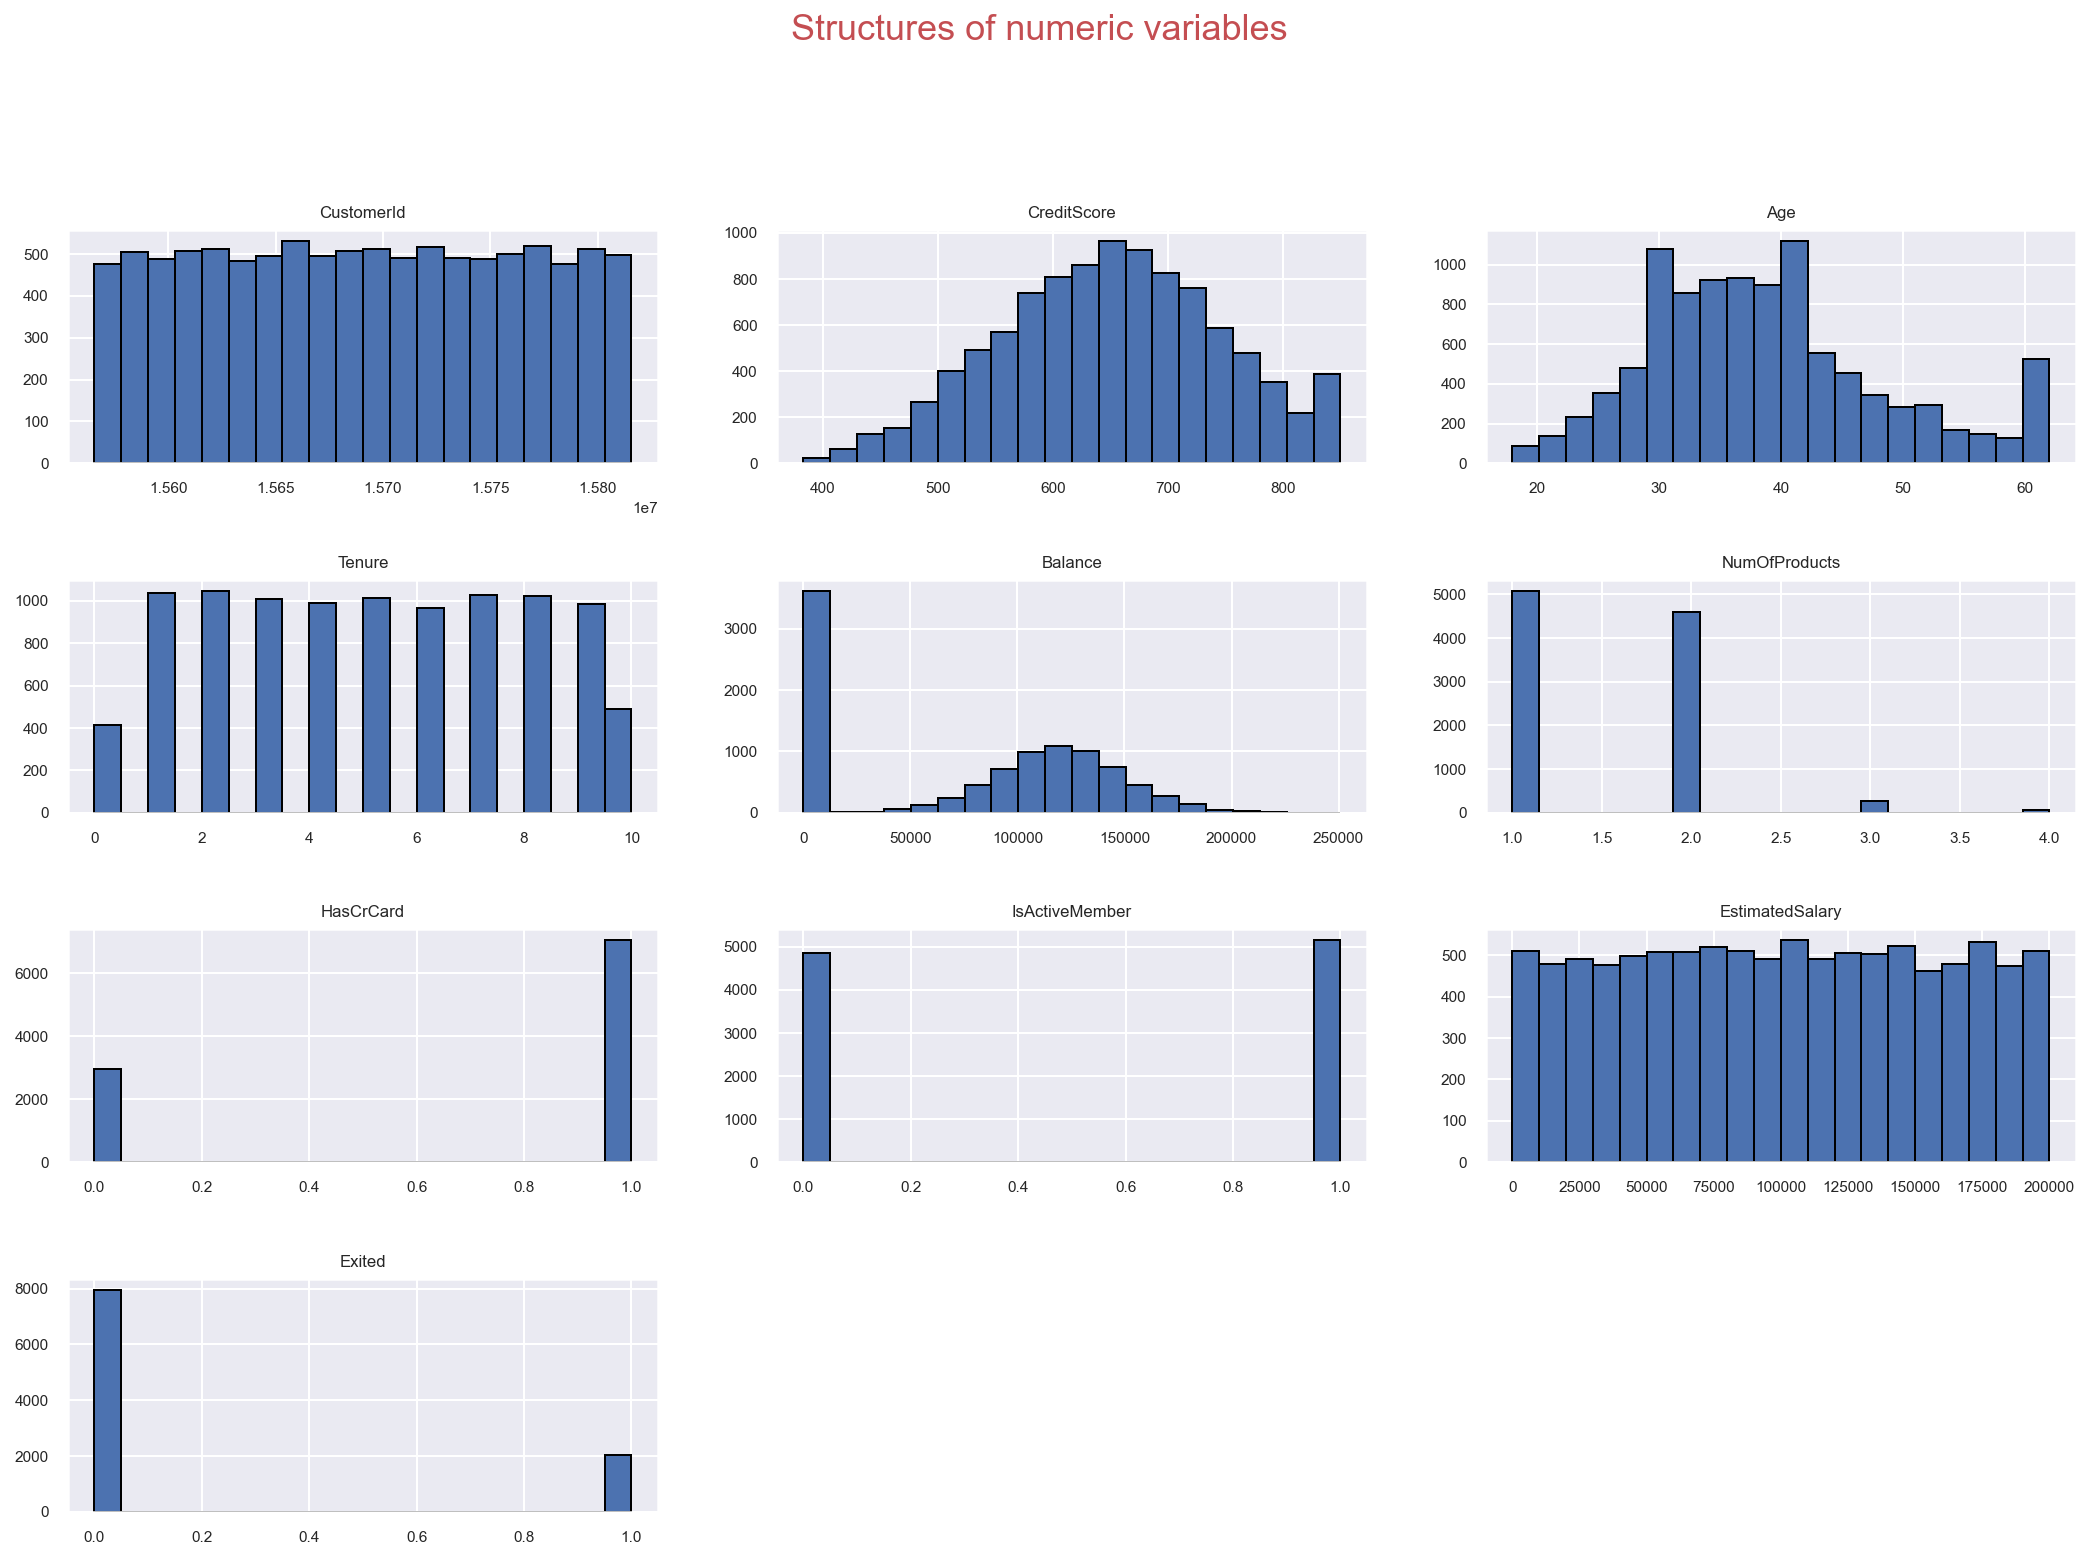

In [34]:
show_numeric_columns_distributions(df_outlier)

In [35]:
def show_dependent_variable_cross_others_distributions(df):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    df_dependent_var = df[df[dependent_variable_name] == 1]
    df_num_cols = df_dependent_var.select_dtypes(include = numerics)
    columns = df_num_cols.columns[: len(df_num_cols.columns)]
    
    fig = plt.figure()
    fig.set_size_inches(18, 15)
    length = len(columns)
    for i,j in itertools.zip_longest(columns, range(length)):
        plt.subplot((length / 2), 3, j+1)
        plt.subplots_adjust(wspace = 0.2, hspace = 0.5)
        df_num_cols[i].hist(bins = 20, edgecolor = 'black')
        plt.title(i)
    fig = fig.suptitle(dependent_variable_name + ' Status of other variables according to 1 dependent variable', color = 'r', fontsize = 18)
    plt.show()

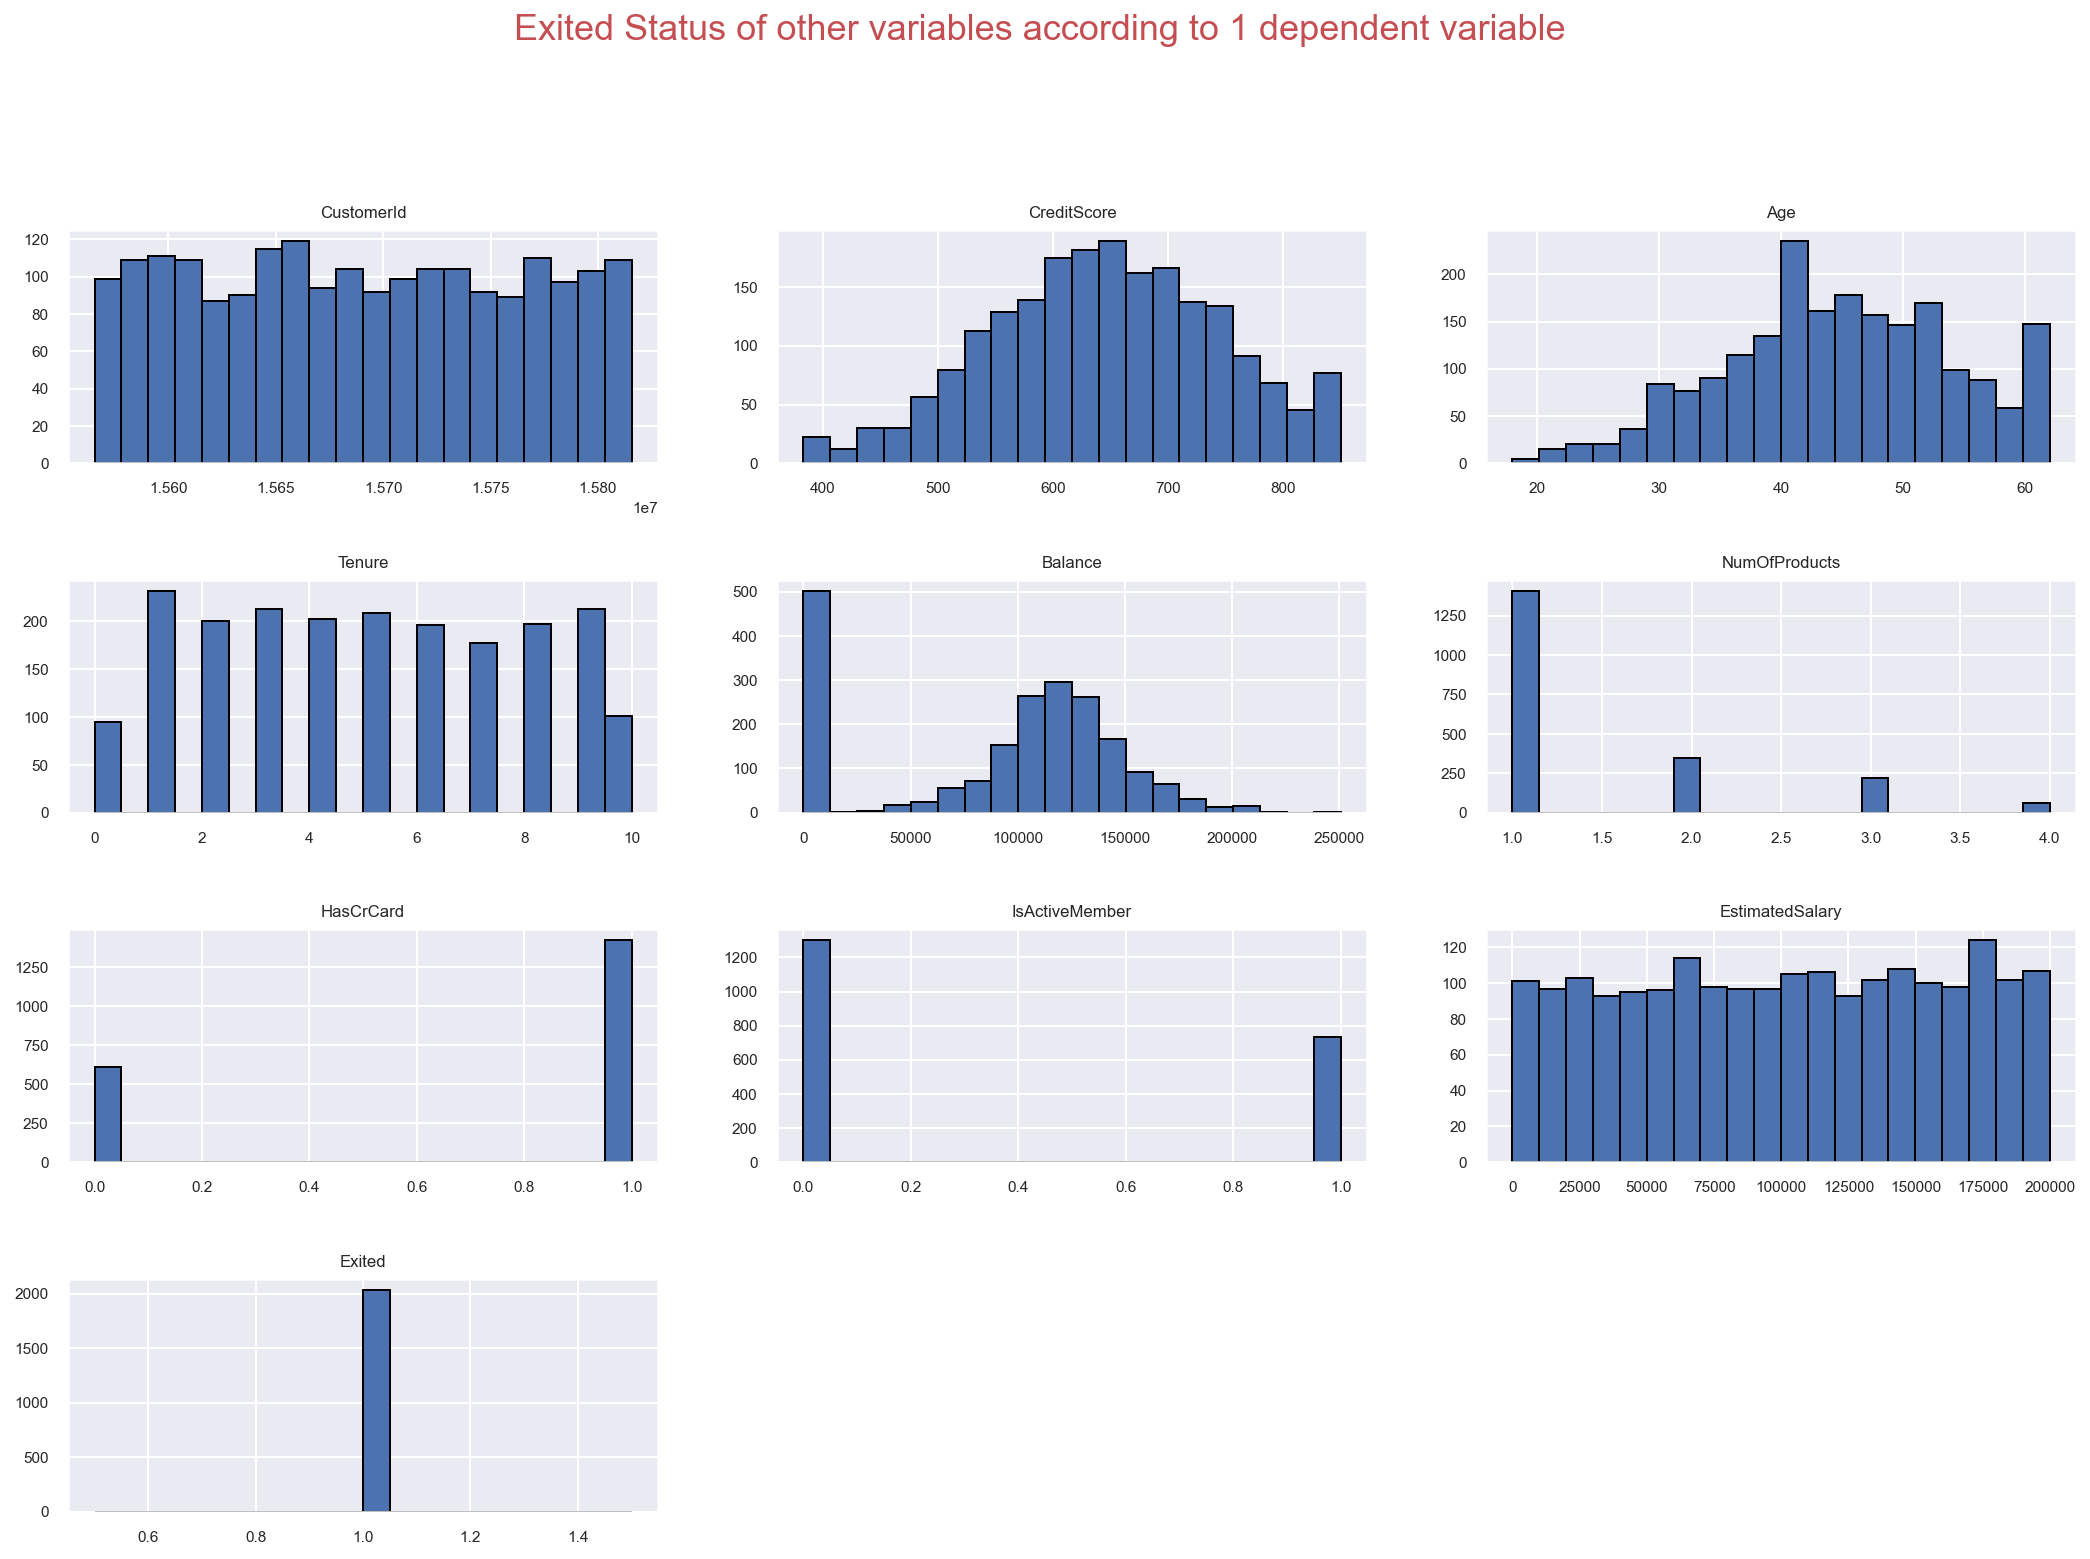

In [36]:
show_dependent_variable_cross_others_distributions(df_outlier)

In [38]:
def show_dependent_variable_cross_categorical_distributions(df, categorical_columns):
    sns.set(font_scale = 0.7) 
    fig, axes = plt.subplots(nrows = int( len(categorical_columns) / 2 ) , ncols = 2, figsize = (7,9))
    fig.tight_layout()
    for ax,col in zip(axes.flatten(), categorical_columns):
        sns.countplot(x = df[col], hue = dependent_variable_name, data = df, ax = ax)
    fig.suptitle('Categorical variables are monitored according to the dependent variable', color = 'r', fontsize = 1)
  

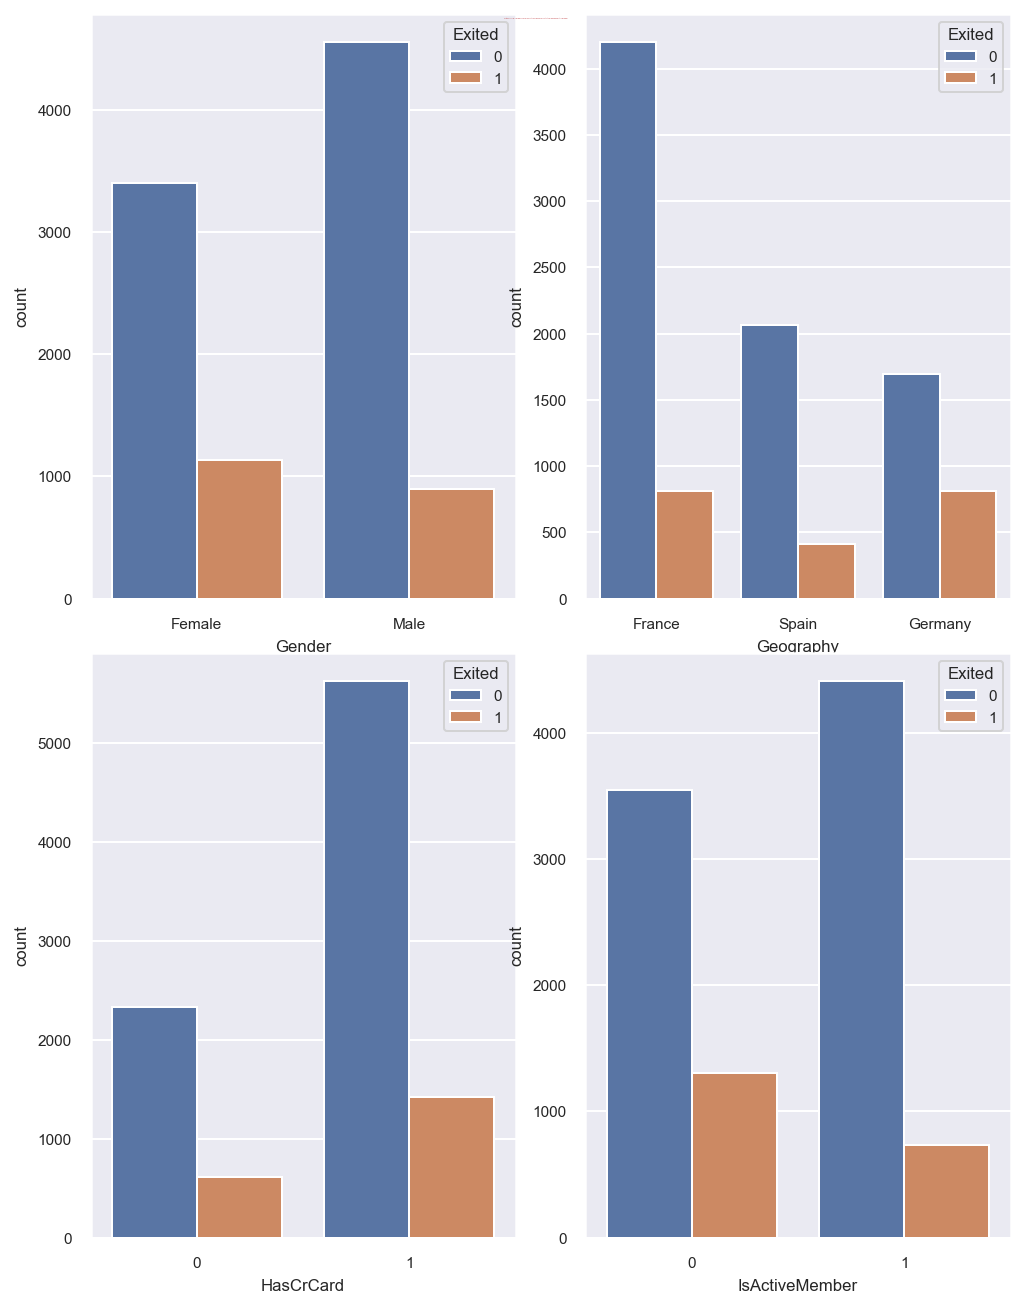

In [39]:
show_dependent_variable_cross_categorical_distributions(df_outlier, categorical_columns = ["Gender","Geography","HasCrCard","IsActiveMember"])

# Feature Engineering

In [40]:
def credit_score_table(row):
    credit_score = row.CreditScore
    if credit_score >= 300 and credit_score < 500:
        return "Very_Poor"
    elif credit_score >= 500 and credit_score < 601:
        return "Poor"
    elif credit_score >= 601 and credit_score < 661:
        return "Fair"
    elif credit_score >= 661 and credit_score < 781:
        return "Good"
    elif credit_score >= 851:
        return "Top"
    elif credit_score >= 781 and credit_score < 851:
        return "Excellent"
    elif credit_score < 300:
        return "Deep"

In [41]:
def product_utilization_rate_by_year(row):
    number_of_products = row.NumOfProducts
    tenure = row.Tenure
    
    if number_of_products == 0:
        return 0
    
    if tenure == 0:
        return number_of_products
    
    rate = number_of_products / tenure
    return rate

In [42]:

def product_utilization_rate_by_estimated_salary(row):
    number_of_products = row.number_of_products
    estimated_salary = row.EstimatedSalary
    
    if number_of_products == 0:
        return 0

    
    rate = number_of_products / estimated_salary
    return rate

In [43]:
def countries_monthly_average_salaries(row):
    fr = 3696    
    de = 4740
    sp = 2257
    salary = row.EstimatedSalary / 12
    country = row.Geography # Germany, France and Spain
    
    if country == 'Germany':
        return salary / de
    elif country == "France":
        return salary / fr
    elif country == "Spain": 
        return salary / sp

In [44]:
def feature_engineering(df, is_show_graph = False):
    df_fe = df.copy()
    
    df_fe['balance_salary_rate'] = df_fe.Balance / df_fe.EstimatedSalary
    
    df_fe = df_fe.assign(product_utilization_rate_by_year=df_fe.apply(lambda x: product_utilization_rate_by_year(x), axis=1)) 
    
    #df_fe = df_fe.assign(product_utilization_rate_by_estimated_salary = df_fe.apply(lambda x: product_utilization_rate_by_estimated_salary(x), axis=1)) 
    
    df_fe['tenure_rate_by_age'] = df_fe.Tenure / (df_fe.Age-17)
    
    df_fe['credit_score_rate_by_age'] = df_fe.CreditScore / (df_fe.Age-17)
    
    #df_fe['product_utilization_rate_by_salary'] = df_fe.Tenure / (df_fe.EstimatedSalary)
   
    df_fe['credit_score_rate_by_salary'] = df_fe.CreditScore / (df_fe.EstimatedSalary)
    
    if is_show_graph:
        fig, axes = plt.subplots(nrows = 2, ncols = 2, figsize = (20,12))
        fig.tight_layout()
        sns.boxplot(y = balance_salary_rate, x = dependent_variable_name, hue = dependent_variable_name, data = df_fe, ax = axes[0][0])
        sns.boxplot(y = product_utilization_rate_by_year, x = dependent_variable_name, hue = dependent_variable_name, data = df_fe, ax = axes[0][1])
        #sns.countplot(x = credit_score_rate_by_age, hue = dependent_variable_name, data = df_fe, ax = axes[1][0])
        #sns.countplot(x = credit_score_rate_by_age, hue = dependent_variable_name, data = df_fe, ax = axes[1][1])
        plt.ylim(-1, 5)
    
    df_fe = df_fe.assign(credit_score_table=df_fe.apply(lambda x: credit_score_table(x), axis=1))
    df_fe = df_fe.assign(countries_monthly_average_salaries = df_fe.apply(lambda x: countries_monthly_average_salaries(x), axis=1)) 
    return df_fe

In [45]:
df_fe = feature_engineering(df = df_outlier)
df_fe.head(10)

,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,balance_salary_rate,product_utilization_rate_by_year,tenure_rate_by_age,credit_score_rate_by_age,credit_score_rate_by_salary,credit_score_table,countries_monthly_average_salaries
RowNumber,,,,,,,,,,,,,,,,,,,,
1,15634602,Hargrave,619.00,France,Female,42.00,2.00,0.00,1.00,1,1,101348.88,1,0.00,0.50,0.08,24.76,0.01,Fair,2.29
2,15647311,Hill,608.00,Spain,Female,41.00,1.00,83807.86,1.00,0,1,112542.58,0,0.74,1.00,0.04,25.33,0.01,Fair,4.16
3,15619304,Onio,502.00,France,Female,42.00,8.00,159660.80,3.00,1,0,113931.57,1,1.40,0.38,0.32,20.08,0.00,Poor,2.57
4,15701354,Boni,699.00,France,Female,39.00,1.00,0.00,2.00,0,0,93826.63,0,0.00,2.00,0.05,31.77,0.01,Good,2.12
5,15737888,Mitchell,850.00,Spain,Female,43.00,2.00,125510.82,1.00,1,1,79084.10,0,1.59,0.50,0.08,32.69,0.01,Excellent,2.92
6,15574012,Chu,645.00,Spain,Male,44.00,8.00,113755.78,2.00,1,0,149756.71,1,0.76,0.25,0.30,23.89,0.00,Fair,5.53
7,15592531,Bartlett,822.00,France,Male,50.00,7.00,0.00,2.00,1,1,10062.80,0,0.00,0.29,0.21,24.91,0.08,Excellent,0.23
8,15656148,Obinna,383.00,Germany,Female,29.00,4.00,115046.74,4.00,1,0,119346.88,1,0.96,1.00,0.33,31.92,0.00,Very_Poor,2.10
9,15792365,He,501.00,France,Male,44.00,4.00,142051.07,2.00,0,1,74940.50,0,1.90,0.50,0.15,18.56,0.01,Poor,1.69


In [46]:
def data_encoding(df):
    df_model = df.copy()
    non_encoding_columns = ["Geography","HasCrCard","IsActiveMember","Gender","NumOfProducts","Tenure","credit_score_table"]
    
    df_non_encoding = df_model[non_encoding_columns]
    df_model = df_model.drop(non_encoding_columns,axis=1)
    
    
    df_encoding = df_non_encoding.copy()
    
    from sklearn.preprocessing import LabelEncoder
    encoder = LabelEncoder()
    df_encoding["gender_category"] = encoder.fit_transform(df_non_encoding.Gender)
    df_encoding["country_category"] = encoder.fit_transform(df_non_encoding.Geography)
    df_encoding["credit_score_category"] = encoder.fit_transform(df_non_encoding.credit_score_table)

    

    df_encoding.reset_index(drop=True, inplace=True)
    df_model.reset_index(drop=True, inplace=True)
    df_model = pd.concat([df_model,df_encoding],axis=1)

    df_model = df_model.drop(["Geography","Gender","CustomerId","Surname","credit_score_table","CreditScore","EstimatedSalary"],axis=1)
    df_model = df_model.reset_index()
    df_model = df_model.drop('index',axis=1)
    
    df_model.loc[df_model.HasCrCard == 0, 'credit_card_situation'] = -1
    df_model.loc[df_model.IsActiveMember == 0, 'is_active_member'] = -1
    return df_model


In [47]:
df_encoded = data_encoding(df_fe)
df_encoded.drop(['credit_card_situation', 'is_active_member'], axis=1, inplace=True)
df_encoded.head(10)

,Age,Balance,Exited,balance_salary_rate,product_utilization_rate_by_year,tenure_rate_by_age,credit_score_rate_by_age,credit_score_rate_by_salary,countries_monthly_average_salaries,HasCrCard,IsActiveMember,NumOfProducts,Tenure,gender_category,country_category,credit_score_category
0,42.00,0.00,1,0.00,0.50,0.08,24.76,0.01,2.29,1,1,1.00,2.00,0,0,1
1,41.00,83807.86,0,0.74,1.00,0.04,25.33,0.01,4.16,0,1,1.00,1.00,0,2,1
2,42.00,159660.80,1,1.40,0.38,0.32,20.08,0.00,2.57,1,0,3.00,8.00,0,0,3
3,39.00,0.00,0,0.00,2.00,0.05,31.77,0.01,2.12,0,0,2.00,1.00,0,0,2
4,43.00,125510.82,0,1.59,0.50,0.08,32.69,0.01,2.92,1,1,1.00,2.00,0,2,0
5,44.00,113755.78,1,0.76,0.25,0.30,23.89,0.00,5.53,1,0,2.00,8.00,1,2,1
6,50.00,0.00,0,0.00,0.29,0.21,24.91,0.08,0.23,1,1,2.00,7.00,1,0,0
7,29.00,115046.74,1,0.96,1.00,0.33,31.92,0.00,2.10,1,0,4.00,4.00,0,1,4
8,44.00,142051.07,0,1.90,0.50,0.15,18.56,0.01,1.69,0,1,2.00,4.00,1,0,3
9,27.00,134603.88,0,1.88,0.50,0.20,68.40,0.01,1.62,1,1,1.00,2.00,1,0,2


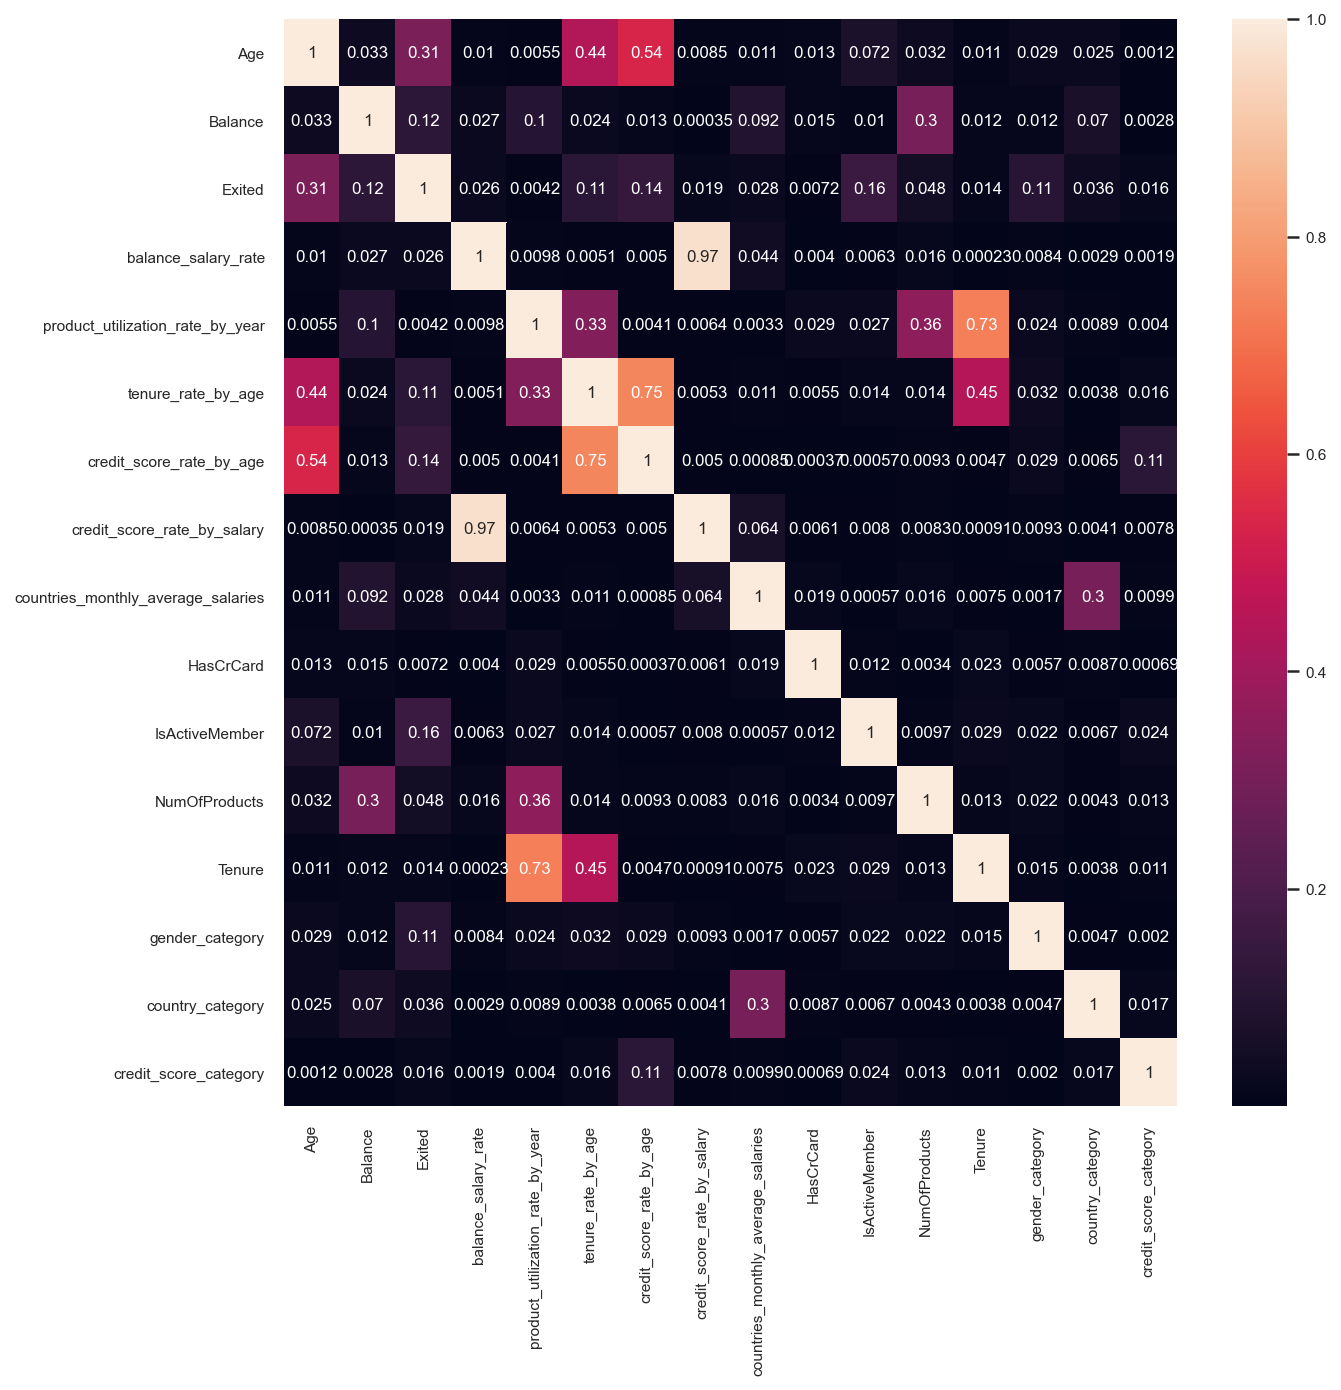

In [48]:
correlation = df_encoded.corr().abs()
plt.figure(figsize=(10,10))
sns.heatmap(correlation, annot=True)
plt.show()

In [49]:
corrs_results = df_encoded.corrwith(df_encoded["Exited"]).abs().nlargest(24)
corrs_results

Exited                               1.00
Age                                  0.31
IsActiveMember                       0.16
credit_score_rate_by_age             0.14
Balance                              0.12
tenure_rate_by_age                   0.11
gender_category                      0.11
NumOfProducts                        0.05
country_category                     0.04
countries_monthly_average_salaries   0.03
balance_salary_rate                  0.03
credit_score_rate_by_salary          0.02
credit_score_category                0.02
Tenure                               0.01
HasCrCard                            0.01
product_utilization_rate_by_year     0.00
dtype: float64

In [50]:
def model_prepare(df_model):
    y = df_model[dependent_variable_name]
    X = df_model.loc[:, df_model.columns != dependent_variable_name]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 12345)
    from sklearn.preprocessing import StandardScaler
    sc = StandardScaler()
    X_train = sc.fit_transform(X_train)
    X_test = sc.transform (X_test)
    return X_train, X_test, y_train, y_test

In [51]:
X_train, X_test, y_train, y_test = model_prepare(df_encoded)

In [52]:
def data_training(X_train, X_test, y_train, y_test):

    models = []
    models.append(('LOGR',LogisticRegression()))
    models.append(('KNN',KNeighborsClassifier()))
    models.append(('CART',DecisionTreeClassifier()))
    models.append(('RF',RandomForestClassifier()))
    #models.append(('SVC',SVC()))
    models.append(('GBM',GradientBoostingClassifier()))
    models.append(('XGBoost',XGBClassifier()))
    models.append(('LightGBM',LGBMClassifier()))
    models.append(('CatBoost',CatBoostClassifier()))

    df_result = pd.DataFrame(columns=["model","accuracy_score","scale_method","0_precision","0_recall","1_precision","1_recall"])
    index = 0
    for name,model in models:
        model.fit(X_train,y_train)
        y_pred = model.predict(X_test)
        score = accuracy_score(y_test,y_pred)
        class_report = classification_report(y_test,y_pred,digits=2,output_dict=True)
        zero_report = class_report['0']
        one_report = class_report['1']
        df_result.at[index,['model','accuracy_score','scale_method',"0_precision","0_recall","1_precision","1_recall"]] = [name,score,"NA",zero_report['precision'],zero_report['recall'],one_report['precision'],one_report['recall']]
        index += 1
    return df_result.sort_values("accuracy_score",ascending=False)

In [53]:
training_result = data_training(X_train, X_test, y_train, y_test)
training_result

[16:44:14] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Learning rate set to 0.025031
0:	learn: 0.6723887	total: 59.7ms	remaining: 59.6s
1:	learn: 0.6528208	total: 64.9ms	remaining: 32.4s
2:	learn: 0.6346845	total: 69.3ms	remaining: 23s
3:	learn: 0.6214616	total: 74.6ms	remaining: 18.6s
4:	learn: 0.6069734	total: 79ms	remaining: 15.7s
5:	learn: 0.5924016	total: 83.3ms	remaining: 13.8s
6:	learn: 0.5784548	total: 87.9ms	remaining: 12.5s
7:	learn: 0.5648268	total: 92.3ms	remaining: 11.4s
8:	learn: 0.5528760	total: 96.7ms	remaining: 10.6s
9:	learn: 0.5413437	total: 101ms	remaining: 9.96s
10:	learn: 0.5303521	total: 105ms	remaining: 9.46s
11:	learn: 0.5194658	total: 110ms	remaining: 9.09s
12:	learn: 0.5110374	total: 115ms	remaining: 8.71s
13:	learn: 0.5014456	total: 11

185:	learn: 0.3159973	total: 948ms	remaining: 4.15s
186:	learn: 0.3158118	total: 953ms	remaining: 4.14s
187:	learn: 0.3156479	total: 957ms	remaining: 4.13s
188:	learn: 0.3155652	total: 964ms	remaining: 4.14s
189:	learn: 0.3154591	total: 969ms	remaining: 4.13s
190:	learn: 0.3152571	total: 975ms	remaining: 4.13s
191:	learn: 0.3151211	total: 980ms	remaining: 4.12s
192:	learn: 0.3149013	total: 988ms	remaining: 4.13s
193:	learn: 0.3147251	total: 992ms	remaining: 4.12s
194:	learn: 0.3145547	total: 996ms	remaining: 4.11s
195:	learn: 0.3144597	total: 1s	remaining: 4.1s
196:	learn: 0.3144269	total: 1s	remaining: 4.09s
197:	learn: 0.3142476	total: 1.01s	remaining: 4.08s
198:	learn: 0.3140804	total: 1.01s	remaining: 4.08s
199:	learn: 0.3139643	total: 1.02s	remaining: 4.07s
200:	learn: 0.3138428	total: 1.02s	remaining: 4.06s
201:	learn: 0.3136805	total: 1.03s	remaining: 4.05s
202:	learn: 0.3135435	total: 1.03s	remaining: 4.04s
203:	learn: 0.3134508	total: 1.03s	remaining: 4.03s
204:	learn: 0.31327

374:	learn: 0.2906680	total: 1.89s	remaining: 3.14s
375:	learn: 0.2905717	total: 1.89s	remaining: 3.14s
376:	learn: 0.2904639	total: 1.9s	remaining: 3.13s
377:	learn: 0.2903534	total: 1.9s	remaining: 3.13s
378:	learn: 0.2902193	total: 1.91s	remaining: 3.12s
379:	learn: 0.2900931	total: 1.91s	remaining: 3.12s
380:	learn: 0.2900148	total: 1.92s	remaining: 3.11s
381:	learn: 0.2898892	total: 1.92s	remaining: 3.11s
382:	learn: 0.2897112	total: 1.93s	remaining: 3.11s
383:	learn: 0.2896099	total: 1.93s	remaining: 3.1s
384:	learn: 0.2894748	total: 1.94s	remaining: 3.09s
385:	learn: 0.2893413	total: 1.94s	remaining: 3.09s
386:	learn: 0.2892046	total: 1.95s	remaining: 3.08s
387:	learn: 0.2890914	total: 1.95s	remaining: 3.08s
388:	learn: 0.2890052	total: 1.96s	remaining: 3.07s
389:	learn: 0.2889283	total: 1.96s	remaining: 3.07s
390:	learn: 0.2888709	total: 1.97s	remaining: 3.06s
391:	learn: 0.2887257	total: 1.97s	remaining: 3.06s
392:	learn: 0.2885698	total: 1.98s	remaining: 3.05s
393:	learn: 0.2

571:	learn: 0.2711718	total: 2.83s	remaining: 2.12s
572:	learn: 0.2710356	total: 2.83s	remaining: 2.11s
573:	learn: 0.2709368	total: 2.83s	remaining: 2.1s
574:	learn: 0.2708220	total: 2.84s	remaining: 2.1s
575:	learn: 0.2707403	total: 2.85s	remaining: 2.09s
576:	learn: 0.2706268	total: 2.85s	remaining: 2.09s
577:	learn: 0.2705040	total: 2.85s	remaining: 2.08s
578:	learn: 0.2703953	total: 2.86s	remaining: 2.08s
579:	learn: 0.2703075	total: 2.87s	remaining: 2.08s
580:	learn: 0.2701949	total: 2.87s	remaining: 2.07s
581:	learn: 0.2701145	total: 2.88s	remaining: 2.06s
582:	learn: 0.2700261	total: 2.88s	remaining: 2.06s
583:	learn: 0.2699668	total: 2.88s	remaining: 2.05s
584:	learn: 0.2698706	total: 2.89s	remaining: 2.05s
585:	learn: 0.2697622	total: 2.89s	remaining: 2.04s
586:	learn: 0.2696419	total: 2.89s	remaining: 2.04s
587:	learn: 0.2695354	total: 2.9s	remaining: 2.03s
588:	learn: 0.2694558	total: 2.9s	remaining: 2.02s
589:	learn: 0.2693535	total: 2.9s	remaining: 2.02s
590:	learn: 0.269

755:	learn: 0.2521366	total: 3.58s	remaining: 1.16s
756:	learn: 0.2520494	total: 3.58s	remaining: 1.15s
757:	learn: 0.2518983	total: 3.59s	remaining: 1.15s
758:	learn: 0.2518109	total: 3.59s	remaining: 1.14s
759:	learn: 0.2517152	total: 3.6s	remaining: 1.14s
760:	learn: 0.2516642	total: 3.6s	remaining: 1.13s
761:	learn: 0.2515362	total: 3.61s	remaining: 1.13s
762:	learn: 0.2514279	total: 3.61s	remaining: 1.12s
763:	learn: 0.2513338	total: 3.62s	remaining: 1.12s
764:	learn: 0.2512581	total: 3.62s	remaining: 1.11s
765:	learn: 0.2511832	total: 3.63s	remaining: 1.11s
766:	learn: 0.2511517	total: 3.63s	remaining: 1.1s
767:	learn: 0.2510831	total: 3.64s	remaining: 1.1s
768:	learn: 0.2509976	total: 3.64s	remaining: 1.09s
769:	learn: 0.2508427	total: 3.65s	remaining: 1.09s
770:	learn: 0.2507556	total: 3.65s	remaining: 1.08s
771:	learn: 0.2506287	total: 3.65s	remaining: 1.08s
772:	learn: 0.2505476	total: 3.66s	remaining: 1.07s
773:	learn: 0.2504173	total: 3.66s	remaining: 1.07s
774:	learn: 0.25

935:	learn: 0.2358843	total: 4.75s	remaining: 325ms
936:	learn: 0.2358340	total: 4.76s	remaining: 320ms
937:	learn: 0.2357130	total: 4.76s	remaining: 315ms
938:	learn: 0.2356103	total: 4.77s	remaining: 310ms
939:	learn: 0.2354937	total: 4.78s	remaining: 305ms
940:	learn: 0.2354341	total: 4.79s	remaining: 300ms
941:	learn: 0.2353269	total: 4.79s	remaining: 295ms
942:	learn: 0.2352758	total: 4.8s	remaining: 290ms
943:	learn: 0.2351857	total: 4.8s	remaining: 285ms
944:	learn: 0.2350296	total: 4.81s	remaining: 280ms
945:	learn: 0.2349049	total: 4.82s	remaining: 275ms
946:	learn: 0.2348434	total: 4.82s	remaining: 270ms
947:	learn: 0.2347871	total: 4.83s	remaining: 265ms
948:	learn: 0.2346684	total: 4.83s	remaining: 260ms
949:	learn: 0.2345741	total: 4.84s	remaining: 255ms
950:	learn: 0.2344562	total: 4.84s	remaining: 250ms
951:	learn: 0.2343679	total: 4.85s	remaining: 245ms
952:	learn: 0.2342984	total: 4.85s	remaining: 239ms
953:	learn: 0.2341962	total: 4.86s	remaining: 234ms
954:	learn: 0.

,model,accuracy_score,scale_method,0_precision,0_recall,1_precision,1_recall
6,LightGBM,0.86,NA,0.88,0.96,0.76,0.48
7,CatBoost,0.86,NA,0.88,0.96,0.76,0.47
4,GBM,0.86,NA,0.87,0.97,0.78,0.44
3,RF,0.86,NA,0.87,0.97,0.77,0.43
5,XGBoost,0.85,NA,0.87,0.95,0.71,0.45
1,KNN,0.84,NA,0.86,0.95,0.67,0.40
0,LOGR,0.81,NA,0.82,0.98,0.70,0.18
2,CART,0.78,NA,0.87,0.86,0.48,0.50


In [54]:
# Detect best model

def best_model(model):
    print(model.best_score_)    
    print(model.best_params_)
    print(model.best_estimator_)
    
def get_auc_scores(y_actual, method,method2):
    auc_score = roc_auc_score(y_actual, method); 
    fpr_df, tpr_df, _ = roc_curve(y_actual, method2); 
    return (auc_score, fpr_df, tpr_df)


from matplotlib import rc,rcParams
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)
    plt.rcParams.update({'font.size': 16})
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45, color="blue")
    plt.yticks(tick_marks, classes, color="blue")

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="red" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [55]:
#LogReg example
logr_model = LogisticRegression().fit(X_train,y_train)
y_pred = logr_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)

print(classification_report(y_test, y_pred, digits=4))
print("Accuracy score of Logistic Regression: ", accuracy)

              precision    recall  f1-score   support

           0     0.8212    0.9805    0.8938      1588
           1     0.7019    0.1772    0.2829       412

    accuracy                         0.8150      2000
   macro avg     0.7616    0.5788    0.5884      2000
weighted avg     0.7966    0.8150    0.7680      2000

Accuracy score of Logistic Regression:  0.815


In [64]:
xgb_model=XGBClassifier(silent=0, learning_rate=0.23, max_delta_step=5,
                            objective='reg:logistic',n_estimators=92, 
                            max_depth=5, eval_metric="logloss", gamma=3,base_score=0.5)
xgb_model.fit(X_train, y_train)
y_pred_xgb = xgb_model.predict(X_test)
print(classification_report(y_test,y_pred_xgb,digits=2))
print("Accuracy score of Tuned XGBoost Regression: ", accuracy_score(y_test, y_pred_xgb))

[16:49:39] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:573: 
Parameters: { "silent" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


              precision    recall  f1-score   support

           0       0.88      0.96      0.92      1588
           1       0.78      0.49      0.60       412

    accuracy                           0.87      2000
   macro avg       0.83      0.72      0.76      2000
weighted avg       0.86      0.87      0.85      2000

Accuracy score of Tuned XGBoost Regression:  0.8655


Confusion matrix, without normalization
[[1531   57]
 [ 212  200]]


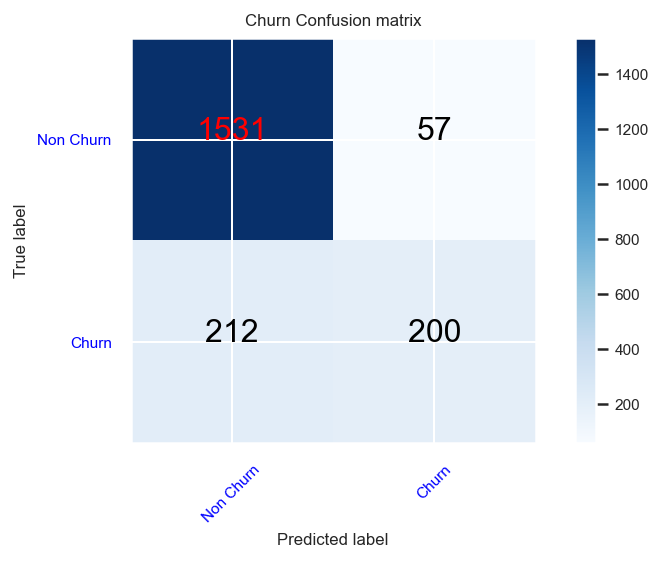

In [65]:
cfm = confusion_matrix(y_test, y_pred_xgb)
plot_confusion_matrix(cfm, classes=['Non Churn','Churn'],
                      title='Churn Confusion matrix')

In [57]:
param_grid = {'max_depth': [3, 5, 6, 7, 8], 'max_features': [2,4,6,7,8,9],'n_estimators' : [50,100], 'min_samples_split': [3, 5, 6, 7]}
randFor_grid = GridSearchCV(RandomForestClassifier(), param_grid, cv = 5, refit = True, verbose = 0)
randFor_grid.fit(X_train,y_train)
best_model(randFor_grid)

KeyboardInterrupt: 

In [66]:
rnd_model = RandomForestClassifier(max_depth=8, max_features=6, min_samples_split=6,n_estimators=50)
rnd_model.fit(X_train, y_train)
y_pred_rf = rnd_model.predict(X_test)
print(classification_report(y_test,y_pred_rf,digits=2))
print("Accuracy score of tuned Random Forest model: ", accuracy_score(y_test, y_pred_rf))

              precision    recall  f1-score   support

           0       0.87      0.97      0.92      1588
           1       0.80      0.42      0.55       412

    accuracy                           0.86      2000
   macro avg       0.83      0.70      0.73      2000
weighted avg       0.85      0.86      0.84      2000

Accuracy score of tuned Random Forest model:  0.859


Confusion matrix, without normalization
[[1546   42]
 [ 240  172]]


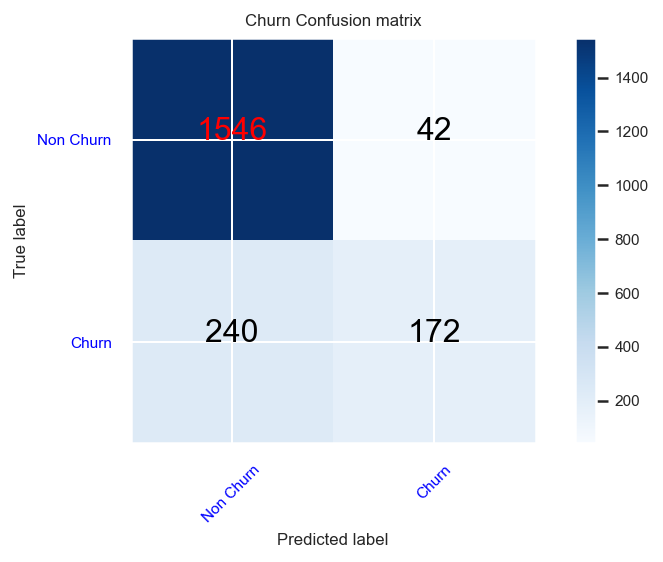

In [67]:
cfm = confusion_matrix(y_test, y_pred_rf)
plot_confusion_matrix(cfm, classes=['Non Churn','Churn'],
                      title='Churn Confusion matrix')

In [69]:
lgbm_model = LGBMClassifier(silent = 0, learning_rate = 0.09, max_delta_step = 2, n_estimators = 100, boosting_type = 'gbdt',
                            max_depth = 10, eval_metric = "logloss", gamma = 3, base_score = 0.5)
lgbm_model.fit(X_train, y_train)
y_pred_lgbm = lgbm_model.predict(X_test)
print(classification_report(y_test, y_pred_lgbm, digits=2))
print("Accuracy score of tuned LightGBM model: ", accuracy_score(y_test, y_pred_lgbm))

[LightGBM] [Warning] Unknown parameter: base_score
[LightGBM] [Warning] Unknown parameter: gamma
[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Unknown parameter: base_score
[LightGBM] [Warning] Unknown parameter: gamma
[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 1624, number of negative: 6373
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002075 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1622
[LightGBM] [Info] Number of data points in the train set: 7997, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.203076 -> initscore=-1.367178
[L

Confusion matrix, without normalization
[[1527   61]
 [ 207  205]]


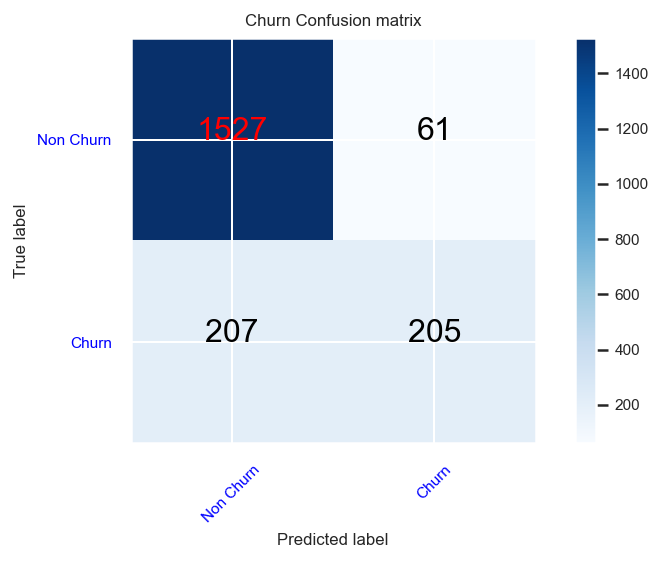

In [70]:
cfm = confusion_matrix(y_test, y_pred_lgbm)
plot_confusion_matrix(cfm, classes=['Non Churn','Churn'],
                      title='Churn Confusion matrix')

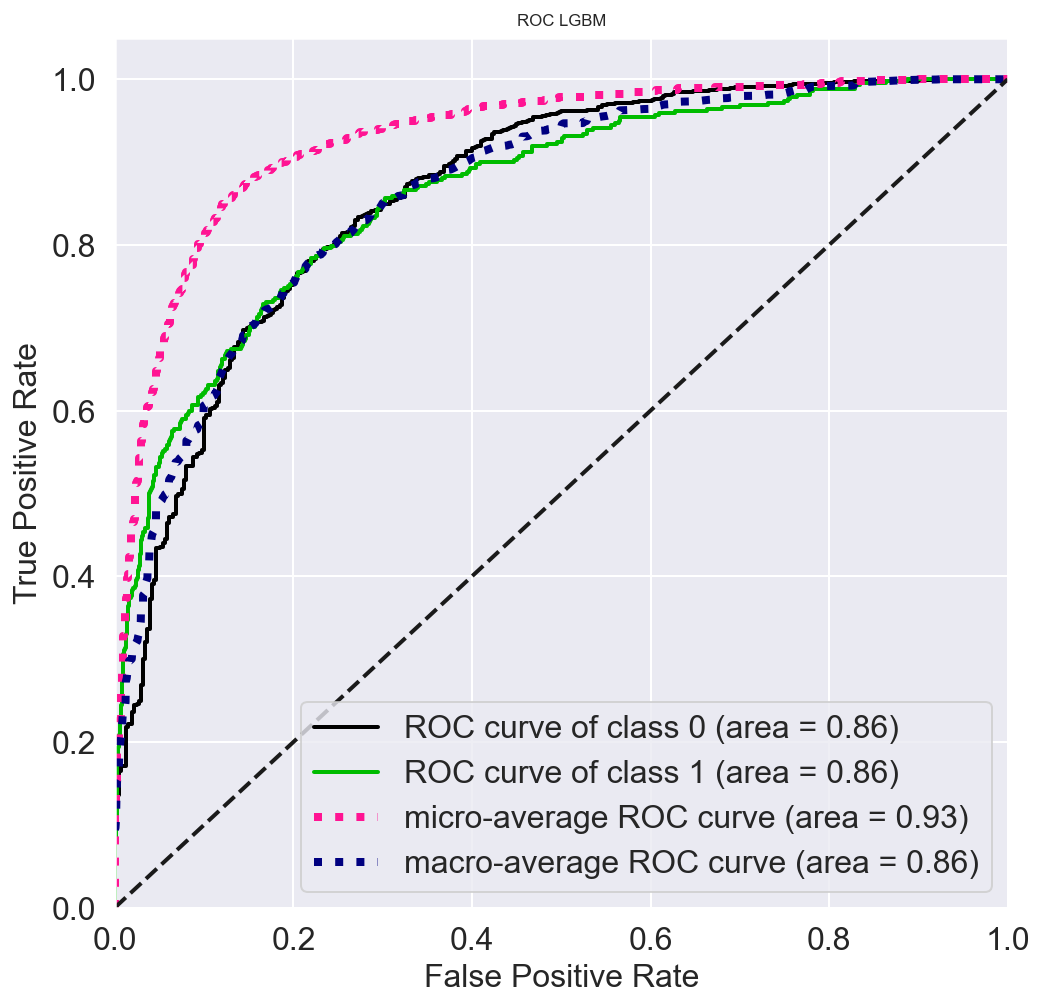

In [72]:
import scikitplot as skplt
y_pred_proba_lgbm = lgbm_model.predict_proba(X_test)
skplt.metrics.plot_roc_curve(y_test, y_pred_proba_lgbm, figsize=(8,8))
plt.title('ROC LGBM')
plt.show()

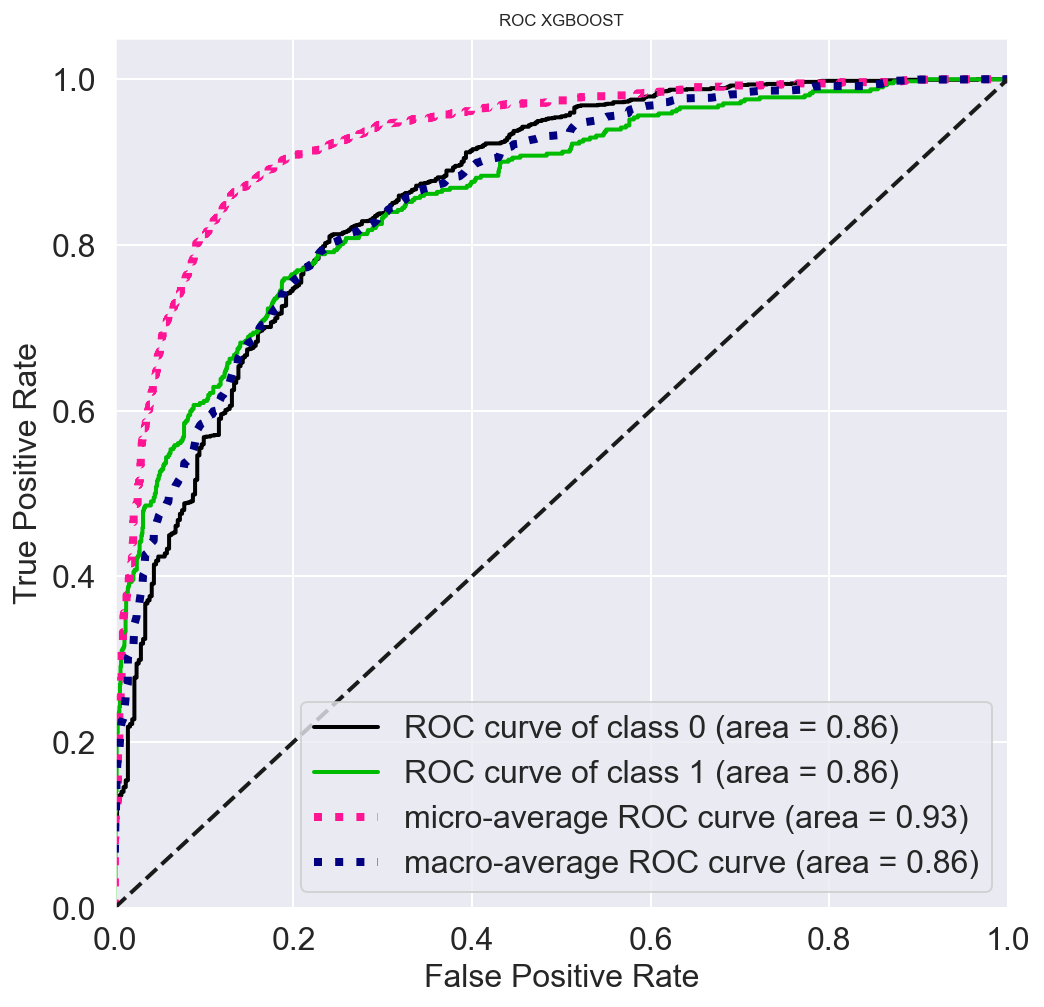

In [73]:
y_pred_proba_xgb = xgb_model.predict_proba(X_test)
skplt.metrics.plot_roc_curve(y_test, y_pred_proba_xgb, figsize=(8,8))
plt.title('ROC XGBOOST')
plt.show()

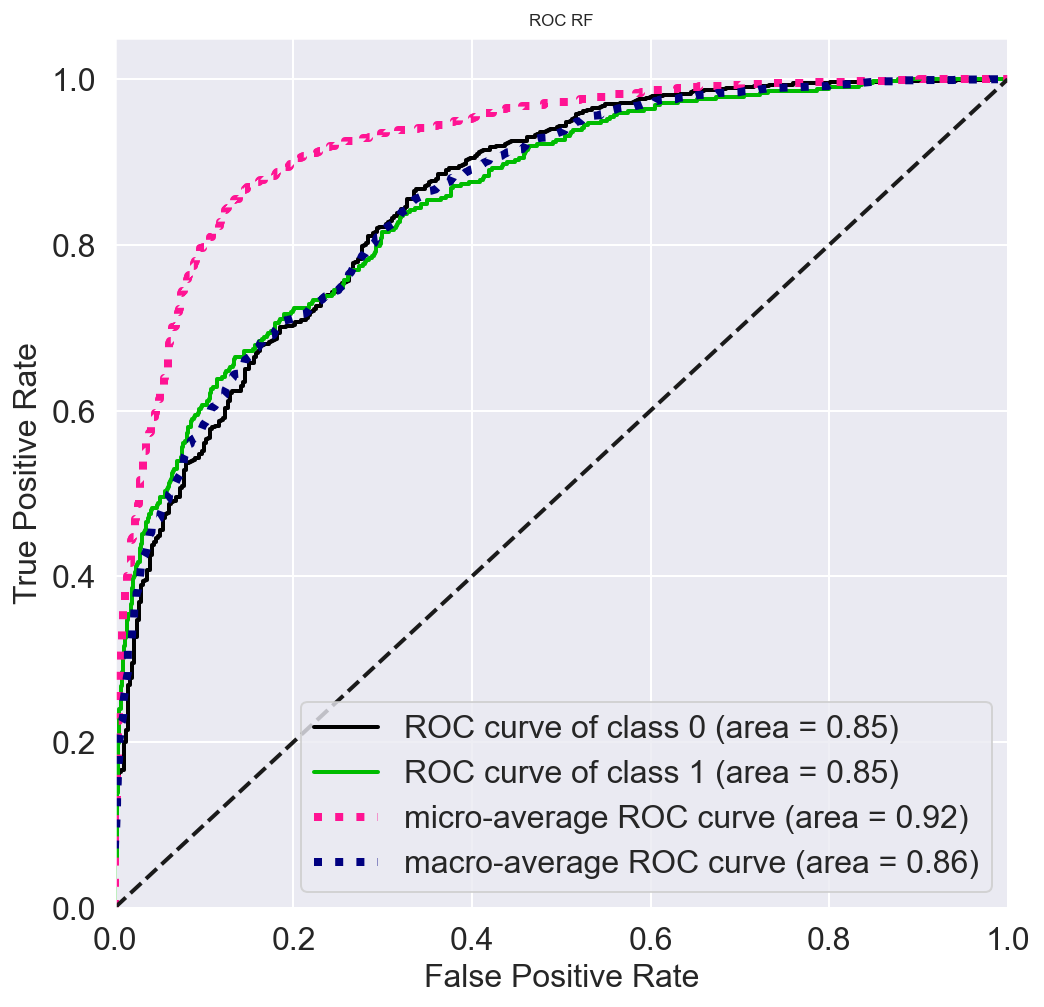

In [74]:
y_pred_proba_rnd = rnd_model.predict_proba(X_test)
skplt.metrics.plot_roc_curve(y_test, y_pred_proba_rnd, figsize=(8,8))
plt.title('ROC RF')
plt.show()

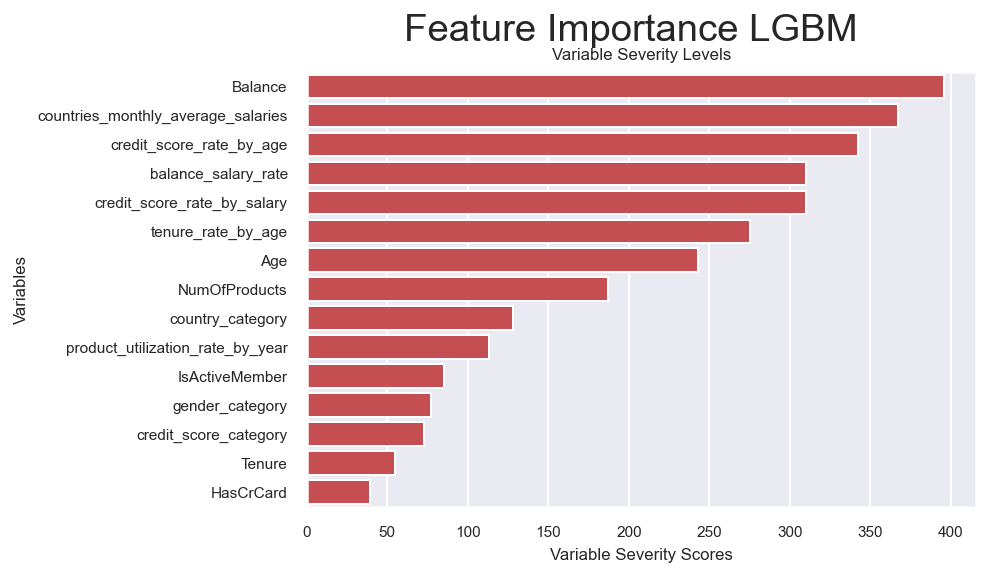

In [77]:
feature_index = df_encoded.loc[:, df_encoded.columns != dependent_variable_name]

feature_importance = pd.Series(lgbm_model.feature_importances_, 
                               index=feature_index.columns).sort_values(ascending=False)
sns.barplot(x = feature_importance, y = feature_importance.index, color='r', saturation=1)
plt.xlabel('Variable Severity Scores')
plt.ylabel('Variables')
plt.title('Variable Severity Levels')
plt.suptitle('Feature Importance LGBM')
plt.show()

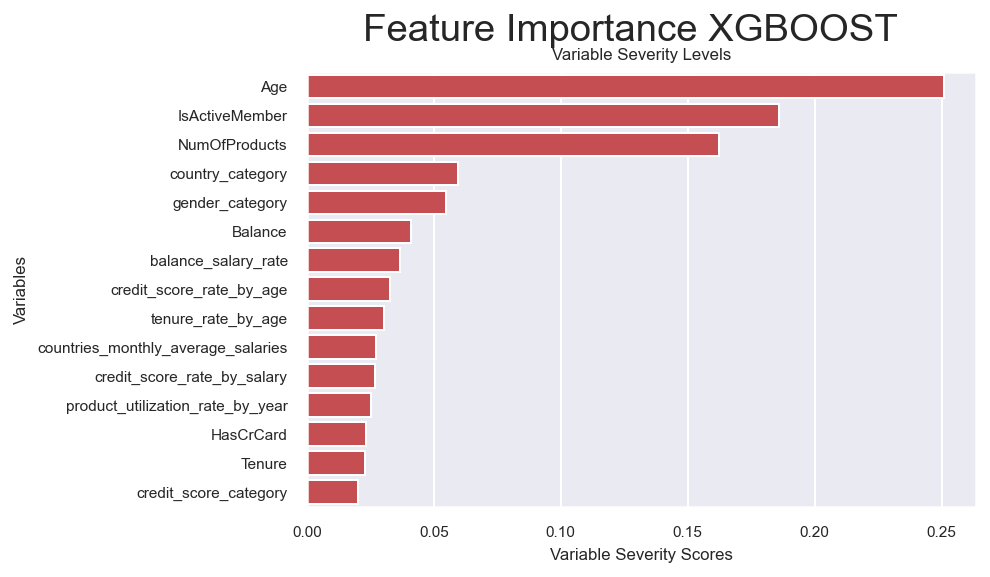

In [78]:
feature_importance = pd.Series(xgb_model.feature_importances_, 
                               index=feature_index.columns).sort_values(ascending=False)
sns.barplot(x = feature_importance, y = feature_importance.index, color='r', saturation=1)
plt.xlabel('Variable Severity Scores')
plt.ylabel('Variables')
plt.title('Variable Severity Levels')
plt.suptitle('Feature Importance XGBOOST')
plt.show()

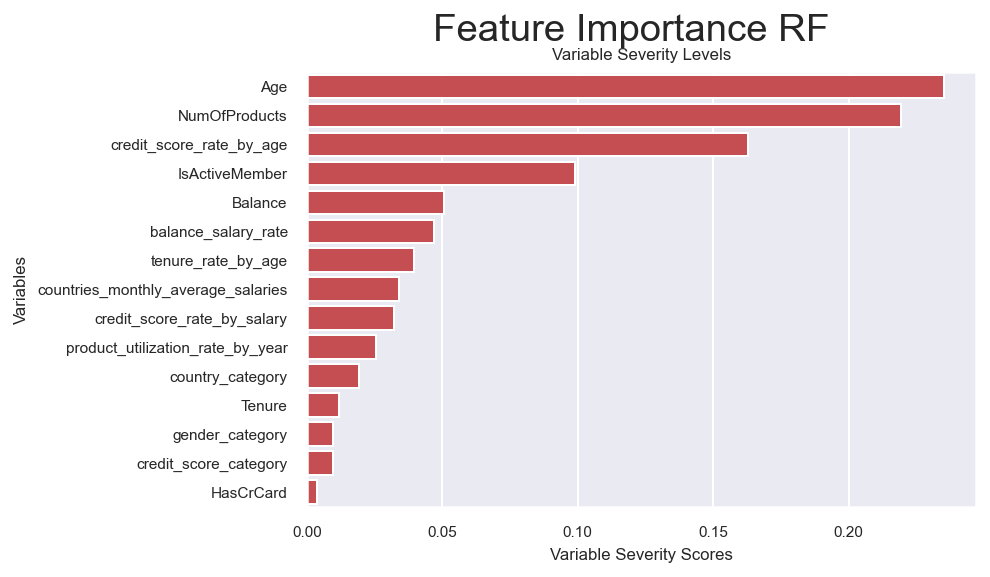

In [79]:
feature_importance = pd.Series(rnd_model.feature_importances_, 
                               index=feature_index.columns).sort_values(ascending=False)
sns.barplot(x = feature_importance, y = feature_importance.index, color='r', saturation=1)
plt.xlabel('Variable Severity Scores')
plt.ylabel('Variables')
plt.title('Variable Severity Levels')
plt.suptitle('Feature Importance RF')
plt.show()